Approach-2<br>
BERT Model with Keras embedding<br>

In [1]:
# Imported required libraries.
!pip install pytorch-pretrained-bert pytorch-nlp
! pip install num2words

import bz2
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

exec(open('/content/preprocess_data.py').read())

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

     |████████████████████████████████| 133kB 8.4MB/s 
     |████████████████████████████████| 92kB 7.6MB/s 
     |████████████████████████████████| 133kB 14.7MB/s 
     |████████████████████████████████| 7.6MB 14.6MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
ERROR: botocore 1.20.92 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 102kB 4.2MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [3]:
#Load AG news data from csb file
sample_data = pd.read_csv('/content/sample.csv')

In [4]:
sample_data.head()

,Class,Title,Article
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


#### Text cleaning

Data Cleaning is performed for removal of junk, sepcial characters, extra white spaces and changing numbers to words.

In [5]:
for i in range(len(sample_data['Article'])):
  sample_data['Article'][i] = preprocess(sample_data['Article'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
sample_data.head()

,Class,Title,Article
0,3,Fears for T N pension after talks,unions representing workers at turner newall ...
1,4,The Race is On: Second Private Team Sets Launc...,space com toronto canada a second team of roc...
2,4,Ky. Company Wins Grant to Study Peptides (AP),ap a company founded by a chemistry researche...
3,4,Prediction Unit Helps Forecast Wildfires (AP),ap its barely dawn when mike fitzpatrick star...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),ap southern californias smog fighting agency ...


In [7]:
label_check = {1 : 0, 2: 1, 3 : 2, 4 : 3}

In [8]:
# Create sentence and label lists
sentences = sample_data['Article']
labels = [label_check[c] for c in sample_data['Class']]

In [9]:
sentences[0]

' unions representing workers at turner newall say they are disappointed after talks with stricken parent firm federal mogul'

In [10]:
voc_size = 10000

In [11]:
onehot_rep = [one_hot(words,voc_size) for words in sentences]

In [12]:
sent_len = 50
dim=5
embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=sent_len)

In [13]:
mymodel=Sequential()
mymodel.add(Embedding(voc_size,dim,input_length=sent_len))
mymodel.compile('adam')

In [14]:
mymodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 5)             50000     
Total params: 50,000
Trainable params: 50,000
Non-trainable params: 0
_________________________________________________________________


In [15]:
n_embedded_docs = mymodel.predict(embedded_docs)

In [16]:
n_embedded_docs[0]

array([[ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.00798862,  0.00425432,  0.03810788],
       [ 0.03169311, -0.01465978,  0.0

In [17]:
input_ids = [x.flatten() for x in n_embedded_docs]

In [18]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2021, test_size=0.2)

In [19]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)
train_labels = torch.tensor(np.array(train_labels))
validation_labels = torch.tensor(np.array(validation_labels))

# Select a batch size for training. 
batch_size = 15

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs,validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [20]:
train_inputs.size()

torch.Size([6080, 250])

In [21]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 4)
model.cuda()

100%|██████████| 407873900/407873900 [00:10<00:00, 40080106.70B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [22]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)


t_total value of -1 results in schedule not being applied


In [23]:

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [24]:
train_dataloader

In [25]:
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):
  
  ## TRAINING
  # Set our model to training mode
  
  model.train()
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_labels = batch 
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, labels=b_labels)
    
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  # VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 1.4024587669983286


Epoch:  25%|██▌       | 1/4 [06:11<18:33, 371.19s/it]

Validation Accuracy: 0.2522875816993461
Train loss: 1.3931472380760268


Epoch:  50%|█████     | 2/4 [12:22<12:22, 371.33s/it]

Validation Accuracy: 0.25424836601307144
Train loss: 1.3898678134227622


Epoch:  75%|███████▌  | 3/4 [18:34<06:11, 371.38s/it]

Validation Accuracy: 0.2522875816993461
Train loss: 1.3874635872582497


Epoch: 100%|██████████| 4/4 [24:45<00:00, 371.49s/it]

Validation Accuracy: 0.2522875816993461


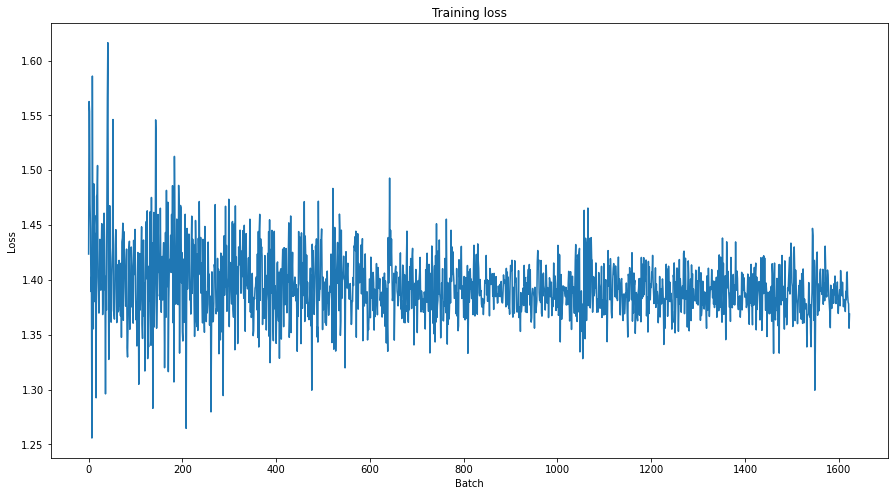

In [26]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()